# Exploring ODF Extraction - Ellipse Data Analysis
## Sam Potter
## Current: 5/16/19

## Path and Imports

In [1]:
import sys
import os

# psfdi
sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\Github\psfdi',
                 'C:/Users/potterst1/Desktop/Repositories/Github/psfdi'])
sys.path.extend(['/workspace/stpotter/git/github/psfdi'])

from psfdi import visualize
from psfdi import fileIO
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import rc
from psfdi import utilities
from psfdi import odf
from psfdi import image_processing as imp
import seaborn as sns
import cv2
import matplotlib

from ipywidgets import *
from scipy import optimize as sciopt
from scipy.integrate import trapz
from scipy.interpolate import interp1d

## BP Data - Load Raw Intensity of 360

In [2]:
# File paths
bp_raw_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\4.28.19\\2) pSFDI\\Sample\\Vertical\\Green'
bp_raw_path = '/workspace/stpotter/Data/pSFDI/2D-Biax-Data/4.28.19/2) pSFDI/Sample/Vertical/Green'

bp_standard_path = 'C:\\Users\\potterst1\\Box Sync\\Research\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\4.28.19\\1) Standard\\Standard\\Vertical\\Green'
bp_standard_path = '/workspace/stpotter/Data/pSFDI/2D-Biax-Data/4.28.19/1) Standard/Sample/Vertical/Green'

In [3]:
# Read
sfx_per = 36.4679
polar_res = 4
polar_max = 360
polar_angles = np.arange(0, polar_max, polar_res)

bp_planar = [cv2.imread(os.path.join(bp_raw_path, 'planar_angle_' + str(angle) + '.tiff'), -1)for angle in polar_angles]
bp_planar = np.array(bp_planar)

## Crop ROI Manually

In [4]:
rowstart, rowstop = 175, 775  # Best: 175, 775
colstart, colstop = 350, 925  # Best: 350, 925

bp_planar = bp_planar[:, rowstart:rowstop, colstart:colstop]

## Load SALS Data

In [5]:
# File Paths
SALS_data_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\SALS\\BP\\Results\\BP ODF 042919'
SALS_data_path = '/workspace/stpotter/Data/pSFDI/SALS/BP ODF 042919'

#SALS_data_dict = fileIO.read_SALS(os.path.join(SALS_data_path, 'SALSA OUT TXT\\BP_ODF_42919_SALSA.txt'))
SALS_data_dict = fileIO.read_SALS(os.path.join(SALS_data_path, 'SALSA OUT TXT/BP_ODF_42919_SALSA.txt'))

In [6]:
# Load data
x = SALS_data_dict['x']
y = SALS_data_dict['y']

PD_2d = SALS_data_dict['PD']
SD_2d = SALS_data_dict['SD']

U = np.cos(np.deg2rad(PD_2d))
V = np.sin(np.deg2rad(PD_2d))

## Register Images

In [7]:
# Load masks
psfdi_mask = cv2.imread(os.path.join(bp_raw_path, 'Mask.tif'), -1)
sals_mask = cv2.imread(os.path.join(SALS_data_path, 'BW_Images\\BP_ODF_42919.png'), -1)
sals_mask = cv2.imread(os.path.join(SALS_data_path, 'BW_Images/BP_ODF_42919.png'), -1)

In [8]:
# Upscale mask
psfdi_mask_upscale = imp.upscale(psfdi_mask, *PD_2d.shape)
sals_mask_upscale = imp.upscale(sals_mask[:, :, 0], *PD_2d.shape)

In [9]:
# Register images
psfdi_mask_registered, warp_data = imp.register(psfdi_mask_upscale.astype(np.uint8), sals_mask_upscale.astype(np.uint8))

print('cc: {}'.format(warp_data['cc']))
print('warp matrix:')
print(warp_data['warp'])

cc: 0.9338341133234805
warp matrix:
[[ 0.9996186   0.0276161   0.14217685]
 [-0.0276161   0.9996186   2.7148695 ]]


In [10]:
# Upscale data
bp_planar_upscale = [imp.upscale(bp_planar[angle, :, :], *PD_2d.shape) for angle in range(len(polar_angles))]
bp_planar_upscale = np.array(bp_planar_upscale)

In [11]:
# Register data
bp_planar_registered = [imp.warp(bp_planar_upscale[angle, :, :], warp_data['warp']) for angle in range(len(polar_angles))]
bp_planar_registered = np.array(bp_planar_upscale)

## Examine Ellipse Data

### Set spot

In [12]:
row = 15
col = 15
ydim = SALS_data_dict['PD'].shape[0]

index = col * ydim + (ydim - col)

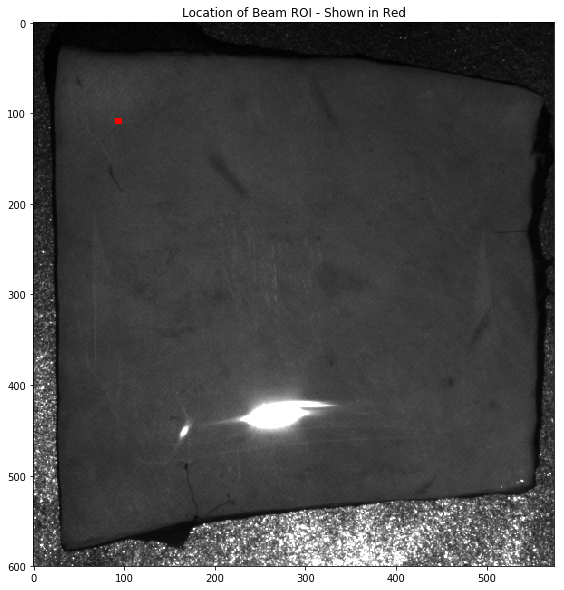

In [13]:
# Visualize
row_step = int(bp_planar.shape[1] / PD_2d.shape[0])
col_step = int(bp_planar.shape[2] / PD_2d.shape[1])

# Get the correct rectangle start indices
psfdi_row = row * row_step
psfdi_col = col * col_step

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(bp_planar[0, :, :], cmap='gray');
rect = patches.Rectangle((psfdi_col, psfdi_row), row_step, col_step, edgecolor='r', facecolor='r')
ax.add_patch(rect);
plt.title('Location of Beam ROI - Shown in Red');

### Fourier Series Fit

In [14]:
# Get SALS data
odf_theta = SALS_data_dict['theta'][index, :]
odf_gamma = SALS_data_dict['odf'][index, :]

In [15]:
# Get pSFDI data, but roll compensate for the different imaging axes
roll = 90 // polar_res

bp_data = bp_planar_registered[:, row, col]
bp_data = np.roll(bp_data, roll)

# Convert polar degrees to radians
polar_angles = np.deg2rad(polar_angles)

In [16]:
# Fit Fourier Series
an, bn, c = odf.fit_fourier(20, odf_gamma, odf_theta)
odf_fsfit = odf.compute_fourier(an, bn, c, odf_theta)

# Compute eigenvalues
theta1, theta2 = odf.structural_eigenval_thetas(an[0], bn[0])
print('Theta I (deg): {}'.format(theta1))
print('Theta II (deg): {}'.format(theta2))

Theta I (deg): -4.388509209957466
Theta II (deg): 85.61149079004254


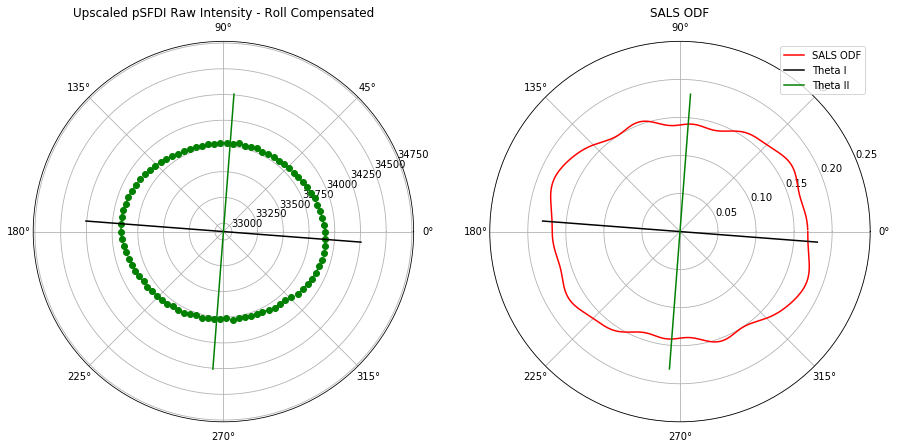

In [17]:
# Visualize
theta1_r = np.deg2rad(theta1)
theta2_r = np.deg2rad(theta2)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15), subplot_kw=dict(projection='polar'))
ax0.plot(polar_angles, bp_data, linestyle='--', marker='o', color='g',
         label='Mean Fiber Intensity');
ax0.set_title('Upscaled pSFDI Raw Intensity - Roll Compensated');
ax0.set_ylim([0.975 * np.min(bp_data), 1.025 * np.max(bp_data)])
ax0.plot([theta1_r, theta1_r + np.pi], [1.01 * np.max(bp_data), 1.01 * np.max(bp_data)], color='k', label='Theta I')
ax0.plot([theta2_r, theta2_r + np.pi], [1.01 * np.max(bp_data), 1.01 * np.max(bp_data)], color='g', label='Theta II')

ax1.plot(odf_theta, odf_gamma, color='r', label='SALS ODF');
ax1.plot([theta1_r, theta1_r + np.pi], [1.01 * np.max(odf_gamma), 1.01 * np.max(odf_gamma)], color='k', label='Theta I')
ax1.plot([theta2_r, theta2_r + np.pi], [1.01 * np.max(odf_gamma), 1.01 * np.max(odf_gamma)], color='g', label='Theta II')
ax1.set_ylim([0, 0.25])
ax1.set_title('SALS ODF');
plt.legend();

### Fit ellipse to pSFDI Data

In [18]:
args_tup = (polar_angles, bp_data)
int_x = [35000, 0, 0]
bounds = ((0, 1000 * np.max(bp_data)), (0.0, 1.0), (0, 2 * np.pi))

minfun = odf.minellipsefun
res = sciopt.differential_evolution(minfun, args=args_tup, bounds=bounds)
print('Final values of b, e, phi: {}'.format(res.x))
print('Final residual: {}'.format(res.fun))
print('Final optimizer success status: {}'.format(res.success))
print('Final optimizer message: {}'.format(res.message))

Final values of b, e, phi: [3.37624310e+04 8.99256023e-02 3.03313216e+00]
Final residual: 12903.911546444626
Final optimizer success status: True
Final optimizer message: Optimization terminated successfully.


/workspace/stpotter/git/github/psfdi/psfdi/odf.py:361: RuntimeWarning: divide by zero encountered in true_divide
  rval = b / np.sqrt(1 - (e * np.cos(theta - phi)) ** 2)
/workspace/stpotter/miniconda/envs/scidev/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/workspace/stpotter/git/github/psfdi/psfdi/odf.py:361: RuntimeWarning: invalid value encountered in sqrt
  rval = b / np.sqrt(1 - (e * np.cos(theta - phi)) ** 2)


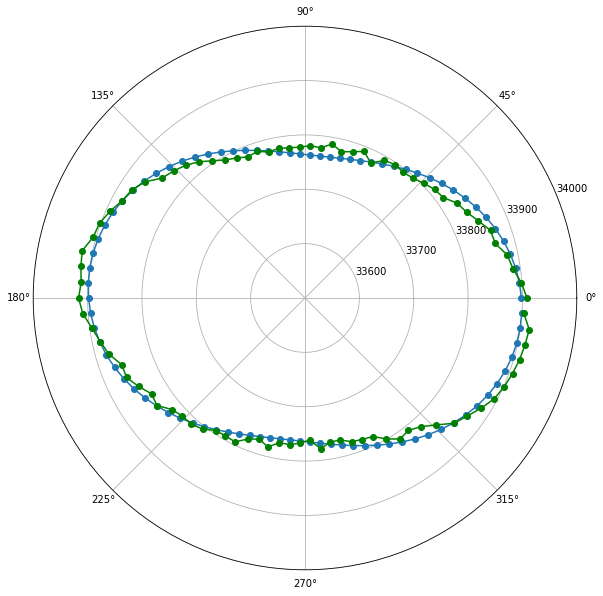

In [19]:
# Visualize fit
fit_ellipse = odf.ellipse(res.x[0], res.x[1], res.x[2], polar_angles)
fig = plt.figure(figsize=(10, 10))
plt.polar(polar_angles, fit_ellipse, marker='o')
plt.polar(polar_angles, bp_data, marker='o', color='g')
plt.ylim([33500, 34000]);

### Remove Pi-Span

In [20]:
# SALS data
lower = odf_theta > np.deg2rad(theta2) 
upper = odf_theta < np.deg2rad(theta2 + 180)
indices = np.all((lower, upper), axis=0)

theta_pi_span = odf_theta[indices]
# Shift this to 0 deg
theta_pi_span = theta_pi_span - np.min(theta_pi_span) * np.ones(len(theta_pi_span))
# Shift this to -pi/2
theta_pi_span = theta_pi_span - np.pi / 2 * np.ones(len(theta_pi_span))
gamma_pi_span = odf_gamma[indices]

In [21]:
# Normalize
gamma_area = trapz(gamma_pi_span, theta_pi_span)

norm_gamma_pi_span = gamma_pi_span / gamma_area

print('Unit Normalized ODF Data Area: {}'.format(trapz(norm_gamma_pi_span, theta_pi_span)))

Unit Normalized ODF Data Area: 1.0


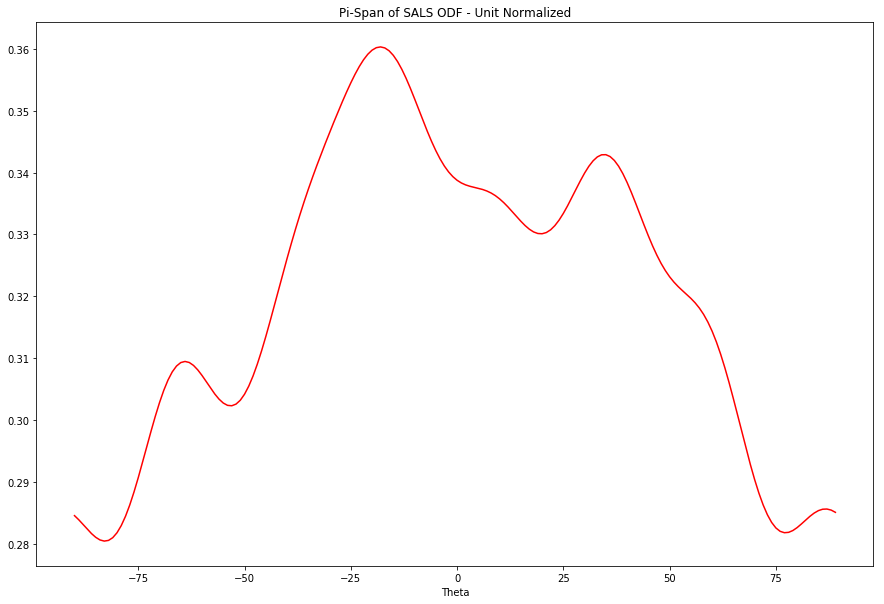

In [22]:
# Visualize
fig = plt.figure(figsize=(15, 10))
plt.plot(np.rad2deg(theta_pi_span), norm_gamma_pi_span, color='r');
plt.title('Pi-Span of SALS ODF - Unit Normalized');
plt.xlabel('Theta');

### Compute mean and standard deviation from SALS ODF

In [23]:
gamma_mean = trapz(theta_pi_span * gamma_pi_span, theta_pi_span)
gamma_var = trapz(gamma_pi_span * np.square(theta_pi_span - np.ones(len(theta_pi_span)) * gamma_mean), theta_pi_span)
gamma_sd = np.sqrt(gamma_var)

print('Mean of Pi-Span (deg): {}'.format(np.rad2deg(gamma_mean)))
print('Standard Deviation of Pi-Span (deg): {}'.format(np.rad2deg(gamma_sd)))

Mean of Pi-Span (deg): -0.20235928102783937
Standard Deviation of Pi-Span (deg): 35.28874307686975


## Fit single pSFDI pixel with Ellipse

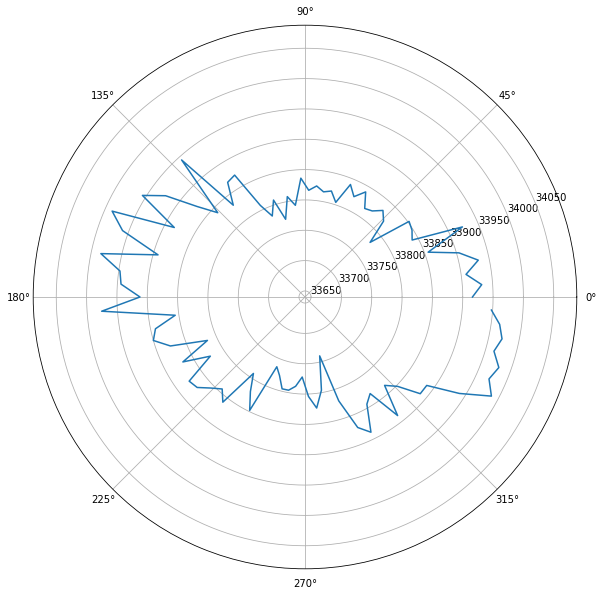

In [24]:
data = np.roll(bp_planar[:, psfdi_row, psfdi_col], roll)
fig = plt.figure(figsize=(10, 10))
plt.polar(polar_angles, data)
plt.ylim([data.min() - 100, data.max() + 100]);

In [25]:
args_tup = (polar_angles, data)
int_x = [35000, 0, 0]
bounds = ((0, 1000 * np.max(bp_data)), (0.0, 1.0), (0, 2 * np.pi))

minfun = odf.minellipsefun
res = sciopt.differential_evolution(minfun, args=args_tup, bounds=bounds)
print('Final values of b, e, phi: {}'.format(res.x))
print('Final residual: {}'.format(res.fun))
print('Final optimizer success status: {}'.format(res.success))
print('Final optimizer message: {}'.format(res.message))

Final values of b, e, phi: [3.37899683e+04 9.32092122e-02 2.94185918e+00]
Final residual: 96971.04369295995
Final optimizer success status: True
Final optimizer message: Optimization terminated successfully.


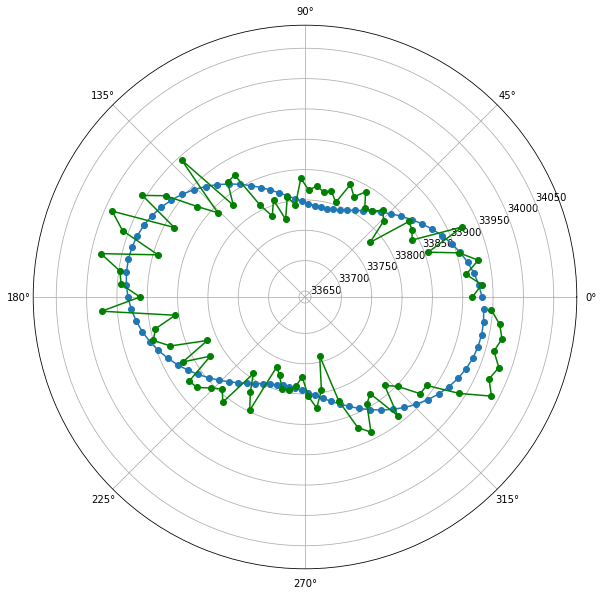

In [26]:
# Visualize fit
fit_ellipse = odf.ellipse(res.x[0], res.x[1], res.x[2], polar_angles)
fig = plt.figure(figsize=(10, 10))
plt.polar(polar_angles, fit_ellipse, marker='o')
plt.polar(polar_angles, data, marker='o', color='g')
plt.ylim([data.min() - 100, data.max() + 100]);

In [27]:
print('b = {}'.format(res.x[1]))
print('SALS sd = {}'.format(np.rad2deg(gamma_sd)))

b = 0.09320921217473604
SALS sd = 35.28874307686975
